## Process Results and Output Analysis
* Author: Callie Clark
* Last Updated: 6/8/2024
* evaluates distributions of the Index for each mode
* Compares the distribution of the Indices based on Need and outputs csv
  

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import networkx as nx
from shapely import wkt
import seaborn as sns

%matplotlib inline
from TT_functions import *
import random
import json
import warnings
import scipy
from scipy import stats
from scipy.stats import chi2_contingency

warnings.filterwarnings("ignore")

In [31]:
#TT based on closest 3 FPs
df_s1=pd.read_csv('processed_df/df_tt_S1_3.csv',index_col=0)
df_s2=pd.read_csv('processed_df/df_tt_S2_3.csv',index_col=0)
df_drive=pd.read_csv('processed_df/df_tt_drive_k10_3.csv',index_col=0)
df_walk=pd.read_csv('processed_df/df_tt_walk_k10_3.csv',index_col=0)
df_bike=pd.read_csv('processed_df/df_tt_bike_k10_3.csv',index_col=0)
df_transit=pd.read_csv('processed_df/df_tt_transit_k25_3.csv',index_col=0)
df_s4=pd.read_csv('processed_df/df_tt_EFAI_3.csv',index_col=0)

##Travel Time based on closest 1 FP
# df_s1=pd.read_csv('processed_df/df_tt_S1.csv',index_col=0)
# df_s2=pd.read_csv('processed_df/df_tt_S2.csv',index_col=0)
# df_drive=pd.read_csv('processed_df/df_tt_drive_k10.csv',index_col=0)
# df_walk=pd.read_csv('processed_df/df_tt_walk_k10.csv',index_col=0)
# df_bike=pd.read_csv('processed_df/df_tt_bike_k10.csv',index_col=0)
# df_transit=pd.read_csv('processed_df/df_tt_transit_k25.csv',index_col=0)
# df_s4=pd.read_csv('processed_df/df_tt_EFAI.csv',index_col=0)

In [32]:

def cutoff_df_TCOL(df,UB,LB,cutoff): #cutoff is used when there is a threshold otherwise the number in each quarter is returned
    df['HHLL']=0

    if cutoff==True:
        print('cutoffs',LB,UB)
        df.loc[df[(df['index']>=UB)&(df['poverty_ind']==1)].index,'HHLL']=3 #high access, High food insecurity
        df.loc[df[(df['index']>=UB)&(df['poverty_ind']==0)].index,'HHLL']=4 #high access, low food insecurity
        df.loc[df[(df['index']<LB)&(df['poverty_ind']==1)].index,'HHLL']=1 #low access, High food insecurity
        df.loc[df[(df['index']<LB)&(df['poverty_ind']==0)].index,'HHLL']=2 #low access, low food insecurity

    else:
        print('Split in to 4 intervals')
        df.loc[df[(df['index']>0.75)].index,'HHLL']=4 #Q4 
        df.loc[df[(df['index']<=0.25)].index,'HHLL']=1 #Q1, 
        df.loc[df[(df['index']<=0.75)&(df['index']>0.5)].index,'HHLL']=3 #Q3, High food insecurity
        df.loc[df[(df['index']<=0.5)&(df['index']>0.25)].index,'HHLL']=2 #low access, High food insecurity

    return df 
    
def plot_HHLL_TCOL(df,stats_df,agg_col,UB,LB,plot_title,fig_title,cutoff):

    df_HHLL= cutoff_df_TCOL(df,UB,LB,cutoff) #what if we did cutoff whole df 

    sns.displot(df_HHLL[agg_col], kde=True, bins=15).set(title=plot_title+ '('+agg_col+')')

    stats_df=calc_stats(df_HHLL,fig_title,stats_df,cutoff)

    return df_HHLL,stats_df

def calc_stats(df_HHLL,fig_title,stats_df,cutoff):

    stats_df.loc[fig_title,'Median Index']=round(df_HHLL['index'].median(),2)
    stats_df.loc[fig_title,'Average Index']=round(df_HHLL['index'].mean(),2)
    
    if cutoff==False:
        stats_df.loc[fig_title,'1']=len(df_HHLL[(df_HHLL['HHLL']==1)&(df_HHLL['poverty_ind']==1)])
        stats_df.loc[fig_title,'2']=len(df_HHLL[(df_HHLL['HHLL']==2)&(df_HHLL['poverty_ind']==1)])
        stats_df.loc[fig_title,'3']=len(df_HHLL[(df_HHLL['HHLL']==3)&(df_HHLL['poverty_ind']==1)])
        stats_df.loc[fig_title,'4']=len(df_HHLL[(df_HHLL['HHLL']==4)&(df_HHLL['poverty_ind']==1)])
        
        stats_df.loc[fig_title,'5']=len(df_HHLL[(df_HHLL['HHLL']==1)&(df_HHLL['poverty_ind']==0)])
        stats_df.loc[fig_title,'6']=len(df_HHLL[(df_HHLL['HHLL']==2)&(df_HHLL['poverty_ind']==0)])
        stats_df.loc[fig_title,'7']=len(df_HHLL[(df_HHLL['HHLL']==3)&(df_HHLL['poverty_ind']==0)])
        stats_df.loc[fig_title,'8']=len(df_HHLL[(df_HHLL['HHLL']==4)&(df_HHLL['poverty_ind']==0)])

    else:
        stats_df.loc[fig_title,'1']=len(df_HHLL[df_HHLL['HHLL']==1])
        stats_df.loc[fig_title,'2']=len(df_HHLL[df_HHLL['HHLL']==2])
        stats_df.loc[fig_title,'3']=len(df_HHLL[df_HHLL['HHLL']==3])
        stats_df.loc[fig_title,'4']=len(df_HHLL[df_HHLL['HHLL']==4])

    
    
    return stats_df    

cutoffs 0.5 0.5


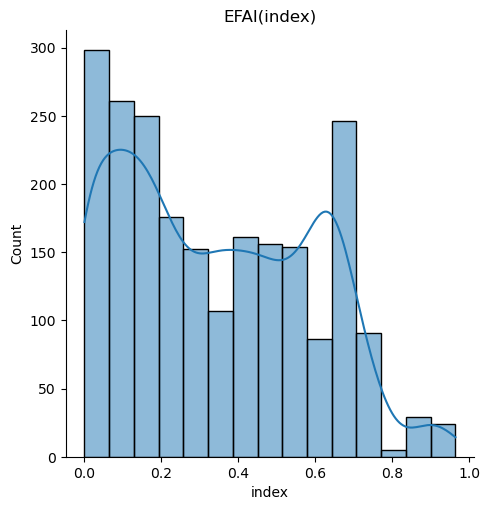

In [26]:
stats_df=pd.DataFrame(columns=['Median Index','Average Index','1','3','2','4'],
                      index=['S1','S2','S3','S4','transit_index','drive_index','bike_index'])
df_HHLL,stats_df=plot_HHLL_TCOL(df_s4,stats_df,'index',UB=0.5,LB=0.5,plot_title='EFAI',fig_title='S4',cutoff=True)

Split in to 4 intervals
Split in to 4 intervals
Split in to 4 intervals
Split in to 4 intervals
Split in to 4 intervals
Split in to 4 intervals
Split in to 4 intervals


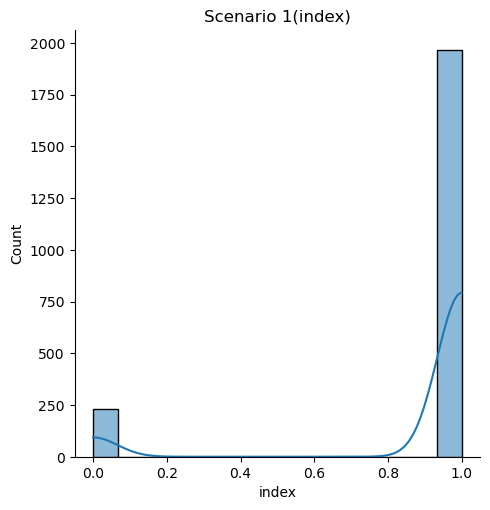

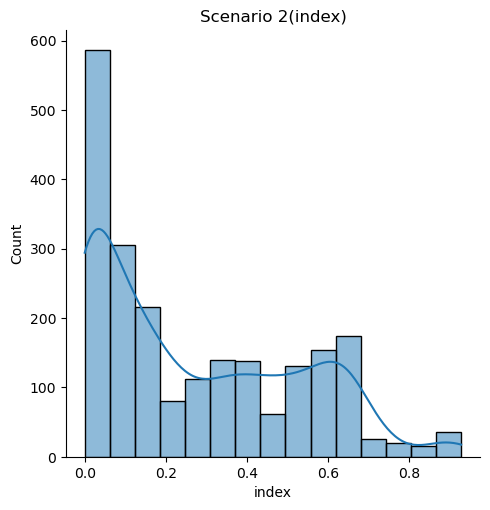

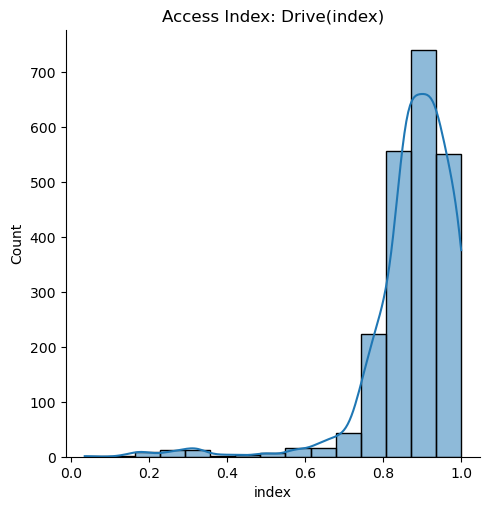

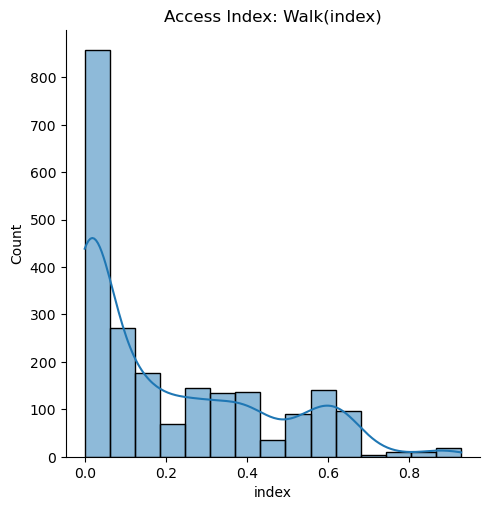

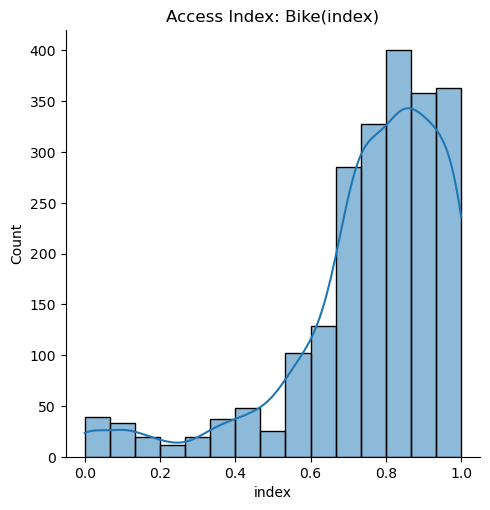

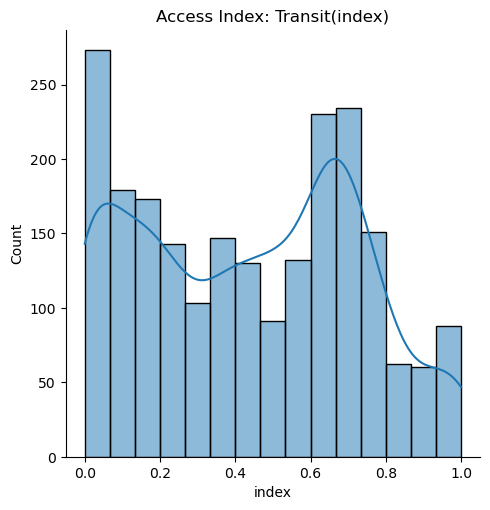

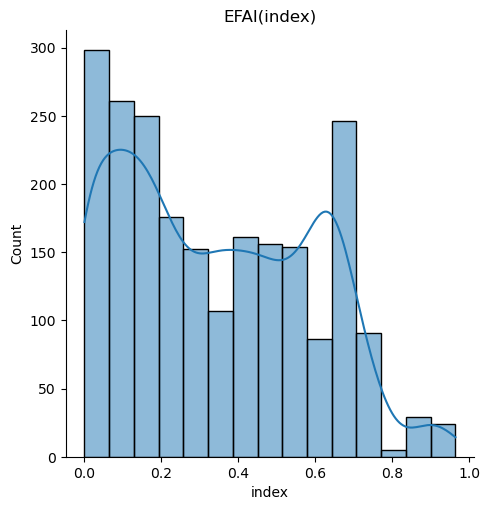

In [33]:
UB=0.75
LB=0.75
cutoff_=False

if cutoff_==False:
    stats_df=pd.DataFrame(columns=['Median Index','Average Index','1','2','3','4'],
                      index=['S1','S2','S4','transit_index','drive_index','bike_index','walk_index'])
else:
    stats_df=pd.DataFrame(columns=['Median Index','Average Index','1','3','2','4'],
                      index=['S1','S2','S4','transit_index','drive_index','bike_index','walk_index'])
observed_data={} #update

df_HHLL,stats_df=plot_HHLL_TCOL(df_s1,stats_df,'index',UB,LB,plot_title='Scenario 1',fig_title='S1',cutoff=cutoff_)
observed_data['S1_below']=[len(df_HHLL[df_HHLL['HHLL']==1]),
                      len(df_HHLL[df_HHLL['HHLL']==3])]
observed_data['S1_above']=[len(df_HHLL[df_HHLL['HHLL']==2]),
                      len(df_HHLL[df_HHLL['HHLL']==4])]

df_HHLL,stats_df=plot_HHLL_TCOL(df_s2,stats_df,'index',UB,LB,plot_title='Scenario 2',fig_title='S2',cutoff=cutoff_)
observed_data['S2_below']=[len(df_HHLL[df_HHLL['HHLL']==1]),
                      len(df_HHLL[df_HHLL['HHLL']==3])]
observed_data['S2_above']=[len(df_HHLL[df_HHLL['HHLL']==2]),
                      len(df_HHLL[df_HHLL['HHLL']==4])]

df_HHLL,stats_df=plot_HHLL_TCOL(df_drive,stats_df,'index',UB,LB,plot_title='Access Index: Drive',fig_title='drive_index',cutoff=cutoff_)
observed_data['drive_index_below']=[df_HHLL['HHLL'].value_counts()[1],
                      df_HHLL['HHLL'].value_counts()[3]]
observed_data['drive_index_above']=[df_HHLL['HHLL'].value_counts()[2],
                      df_HHLL['HHLL'].value_counts()[4]]

df_HHLL,stats_df=plot_HHLL_TCOL(df_walk,stats_df,'index',UB,LB,plot_title='Access Index: Walk',fig_title='walk_index',cutoff=cutoff_)
observed_data['walk_index_below']=[df_HHLL['HHLL'].value_counts()[1],
                      df_HHLL['HHLL'].value_counts()[3]]
observed_data['walk_index_above']=[df_HHLL['HHLL'].value_counts()[2],
                      df_HHLL['HHLL'].value_counts()[4]]

df_HHLL,stats_df=plot_HHLL_TCOL(df_bike,stats_df,'index',UB,LB,plot_title='Access Index: Bike',fig_title='bike_index',cutoff=cutoff_)
observed_data['bike_index_below']=[df_HHLL['HHLL'].value_counts()[1],
                      df_HHLL['HHLL'].value_counts()[3]]
observed_data['bike_index_above']=[df_HHLL['HHLL'].value_counts()[2],
                      df_HHLL['HHLL'].value_counts()[4]]

df_HHLL,stats_df=plot_HHLL_TCOL(df_transit,stats_df,'index',UB,LB,plot_title='Access Index: Transit',fig_title='transit_index',cutoff=cutoff_)
observed_data['transit_index_below']=[df_HHLL['HHLL'].value_counts()[1],
                      df_HHLL['HHLL'].value_counts()[3]]
observed_data['transit_index_above']=[df_HHLL['HHLL'].value_counts()[2],
                      df_HHLL['HHLL'].value_counts()[4]]

df_HHLL,stats_df=plot_HHLL_TCOL(df_s4,stats_df,'index',UB,LB,plot_title='EFAI',fig_title='S4',cutoff=cutoff_)
observed_data['S4_below']=[df_HHLL['HHLL'].value_counts()[1],
                      df_HHLL['HHLL'].value_counts()[3]]
observed_data['S4_above']=[df_HHLL['HHLL'].value_counts()[2],
                      df_HHLL['HHLL'].value_counts()[4]]




In [34]:
for col in stats_df.columns:
    stats_df[col]=stats_df[col].astype('float')
    
if cutoff_==True:
    print('analyzing with cutoff')
    stats_df['1']=round((stats_df['1']/len(df_HHLL[df_HHLL['poverty_ind']==1]))*100)
    stats_df['3']=round((stats_df['3']/len(df_HHLL[df_HHLL['poverty_ind']==1]))*100)
    stats_df['2']=round(stats_df['2']/len(df_HHLL[df_HHLL['poverty_ind']==0])*100)
    stats_df['4']=round(stats_df['4']/len(df_HHLL[df_HHLL['poverty_ind']==0])*100)
    stats_df.rename(columns={'1':'Low Access, High Need','2':'Low Need, High Need','3':'High Access, High Need','4':'High Access, Low Need'},inplace=True)
    
    # Perform chi-squared test
    #H0 --> no relationship between variables
    #p-value of 0.05 --> at which we reject the H0 if P=< 0.05, if p-value>0.05 we accept H0
    stats_df['chi_value']=np.nan
    for i in ['S1','S2','drive_index', 'walk_index', 'bike_index', 'transit_index', 'S4']:
        try: 
            chi2_stat, p_value, dof, expected = chi2_contingency([observed_data[i+'_below'],observed_data[i+'_above']])

            #stats_df.loc[i,'chi_value']=round(p_value,5)
            stats_df.loc[i,'chi_value']=p_value
        except:
            print('error calculating chi for ',i)

    # Print results
        print(i,f"P-value: {p_value}")


else:
    print('Analyzing by quarters')
    # stats_df['1']=round(stats_df['1']/(len(df_HHLL))*100)
    # stats_df['3']=round(stats_df['3']/(len(df_HHLL))*100)
    # stats_df['2']=round(stats_df['2']/(len(df_HHLL))*100)
    # stats_df['4']=round(stats_df['4']/(len(df_HHLL))*100)
    # stats_df.rename(columns={'1':'Q1','2':'Q2','3':'Q3','4':'Q4'},inplace=True)
    
    stats_df['1']=round(stats_df['1']/(len(df_HHLL[df_HHLL['poverty_ind']==1]))*100)
    stats_df['2']=round(stats_df['2']/(len(df_HHLL[df_HHLL['poverty_ind']==1]))*100)
    stats_df['3']=round(stats_df['3']/(len(df_HHLL[df_HHLL['poverty_ind']==1]))*100)
    stats_df['4']=round(stats_df['4']/(len(df_HHLL[df_HHLL['poverty_ind']==1]))*100)
    
    stats_df['5']=round(stats_df['5']/(len(df_HHLL[df_HHLL['poverty_ind']==0]))*100)
    stats_df['6']=round(stats_df['6']/(len(df_HHLL[df_HHLL['poverty_ind']==0]))*100)
    stats_df['7']=round(stats_df['7']/(len(df_HHLL[df_HHLL['poverty_ind']==0]))*100)
    stats_df['8']=round(stats_df['8']/(len(df_HHLL[df_HHLL['poverty_ind']==0]))*100)
    
    stats_df['chi_value']=np.nan
    for i in ['S1','S2','drive_index', 'walk_index', 'bike_index', 'transit_index', 'S4']:

        try: 
            chi2_stat, p_value, dof, expected = chi2_contingency([[stats_df.loc[i,'1'],stats_df.loc[i,'2'],stats_df.loc[i,'3'],stats_df.loc[i,'4']]
                                                    ,[stats_df.loc[i,'5'],stats_df.loc[i,'6'],stats_df.loc[i,'7'],stats_df.loc[i,'8']]])

            #stats_df.loc[i,'chi_value']=round(p_value,5)
            stats_df.loc[i,'chi_value']=p_value
                # Print results
            print(i,f"P-value: {p_value}")
        except:
            print('error calculating chi for ',i)
            
    stats_df.rename(columns={'1':'Q1, High Need','2':'Q2, High Need','3':'Q3, High Need','4':'Q4, High Need',
                            '5':'Q1, Low Need','6':'Q2, Low Need','7':'Q3, Low Need','8':'Q4, Low Need'},inplace=True)




stats_df.rename(index={'S4':'EFAI', 'transit_index':'Transit index', 'drive_index':'Drive index', 'bike_index':'Bike Index',
   'walk_index':'Walk Index'},inplace=True)
stats_df

Analyzing by quarters
error calculating chi for  S1
S2 P-value: 0.008199868527776818
drive_index P-value: 0.5577091861512602
walk_index P-value: 0.05757475347368963
bike_index P-value: 0.008879768357911186
transit_index P-value: 0.0003085304806091591
S4 P-value: 0.020680889379560502


,Median Index,Average Index,"Q1, High Need","Q2, High Need","Q3, High Need","Q4, High Need","Q1, Low Need","Q2, Low Need","Q3, Low Need","Q4, Low Need",chi_value
S1,1.00,0.89,4.0,0.0,0.0,96.0,17.0,0.0,0.0,83.0,NaN
S2,0.18,0.27,47.0,26.0,27.0,1.0,66.0,17.0,13.0,4.0,0.008200
EFAI,0.32,0.34,36.0,29.0,34.0,1.0,53.0,24.0,19.0,4.0,0.020681
Transit index,0.46,0.44,24.0,24.0,43.0,9.0,46.0,19.0,19.0,16.0,0.000309
Drive index,0.89,0.88,0.0,1.0,6.0,93.0,1.0,2.0,9.0,88.0,0.557709
Bike Index,0.82,0.76,2.0,1.0,32.0,65.0,7.0,10.0,31.0,52.0,0.008880
Walk Index,0.11,0.21,57.0,24.0,18.0,1.0,74.0,13.0,11.0,2.0,0.057575


In [35]:
stats_df.loc[['S1', 'S2', 'EFAI', 'Walk Index','Transit index', 'Drive index', 'Bike Index',],]

,Median Index,Average Index,"Q1, High Need","Q2, High Need","Q3, High Need","Q4, High Need","Q1, Low Need","Q2, Low Need","Q3, Low Need","Q4, Low Need",chi_value
S1,1.00,0.89,4.0,0.0,0.0,96.0,17.0,0.0,0.0,83.0,NaN
S2,0.18,0.27,47.0,26.0,27.0,1.0,66.0,17.0,13.0,4.0,0.008200
EFAI,0.32,0.34,36.0,29.0,34.0,1.0,53.0,24.0,19.0,4.0,0.020681
Walk Index,0.11,0.21,57.0,24.0,18.0,1.0,74.0,13.0,11.0,2.0,0.057575
Transit index,0.46,0.44,24.0,24.0,43.0,9.0,46.0,19.0,19.0,16.0,0.000309
Drive index,0.89,0.88,0.0,1.0,6.0,93.0,1.0,2.0,9.0,88.0,0.557709
Bike Index,0.82,0.76,2.0,1.0,32.0,65.0,7.0,10.0,31.0,52.0,0.008880


In [22]:
#stats_df.loc[['S1', 'S2', 'EFAI', 'Walk Index','Transit index', 'Drive index', 'Bike Index',],].to_csv('outputs/cutoff_0.75_tt_3.csv')